This notebook loads the unfiltered unwrapped igrams, makes some time series between an area that I'm choosing as a reference region and compares it with the average over the whole igram, and compares it to a point in LS 

This notebook: <br>
1. loads in unfiltered, unwrapped igrams 
2. extracts time series between 2 regions of pixels (reference region and average over entire igram), plots it

?? does it still do these things? Wait and see. 
3. extracts clusters of time series between pairs from 10x10 areas
4. plots 1sigma above - 1sigma below median 

This notebook was written on 2-17-23

***

In [1]:
# import stuff
import os,sys
import glob
import pandas
from osgeo import gdal
import datetime 
from datetime import datetime
from datetime import timedelta
from dateutil import parser
import numpy as np
from scipy.ndimage import gaussian_filter
from scipy.stats import skew
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
%matplotlib  widget

Read in unfiltered, unwrapped igrams. Can take a few minutes.

In [2]:
# igramsDir is where the cropped, unwrapped igrams are 
igramsDir = '/data/ocp4/LagunaSalada/cropped_9000_1800_18000_3600/cropped_northern_shore_LS_for_unwrapping/unfilt_unwrapped/'
igramsDir2 = '/data/ocp4/LagunaSalada/cropped_9000_1800_18000_3600/cropped_northern_shore_LS_for_unwrapping/filt_unwrapped/'
# this one is to pick out the dates 
datesDir = '/data/ocp4/LagunaSalada/cropped_9000_1800_18000_3600/'
# shape of unwrapped igrams
dx = 3000
dy = 750
# load in dates, make sure they are in order
dates = [os.path.basename(x) for x in glob.glob(datesDir+"SLC_vh/2*")]; dates = sorted(dates)
nd = len(dates); numIgrams = nd-1
# set the driver first, only do once.
driver=gdal.GetDriverByName('ISCE')
unwr_full_res = np.ndarray((numIgrams,dy,dx),dtype='float')
unwr_filt = np.ndarray((numIgrams,dy,dx),dtype='float')
# loop through the dates 
for i in range(numIgrams): # numIgrams if doing all of them at once
    date1=dates[i]
    date2=dates[i+1]
    igramFile = igramsDir+date1+'_'+date2+'_unfilt.unw'
    ds = gdal.Open(igramFile,gdal.GA_ReadOnly)
    unwr_full_res[i] = ds.GetRasterBand(1).ReadAsArray(0,0,dx,dy)
    igramFile = igramsDir2+date1+'_'+date2+'_filt.unw'
    ds = gdal.Open(igramFile,gdal.GA_ReadOnly)
    unwr_filt[i] = ds.GetRasterBand(1).ReadAsArray(0,0,dx,dy)
print('unfiltered unwrapped igrams loaded.')
print('filtered unwrapped igrams loaded.')

unfiltered unwrapped igrams loaded.
filtered unwrapped igrams loaded.


Optional: Plot a sample interferogram with a box around a potential reference area.

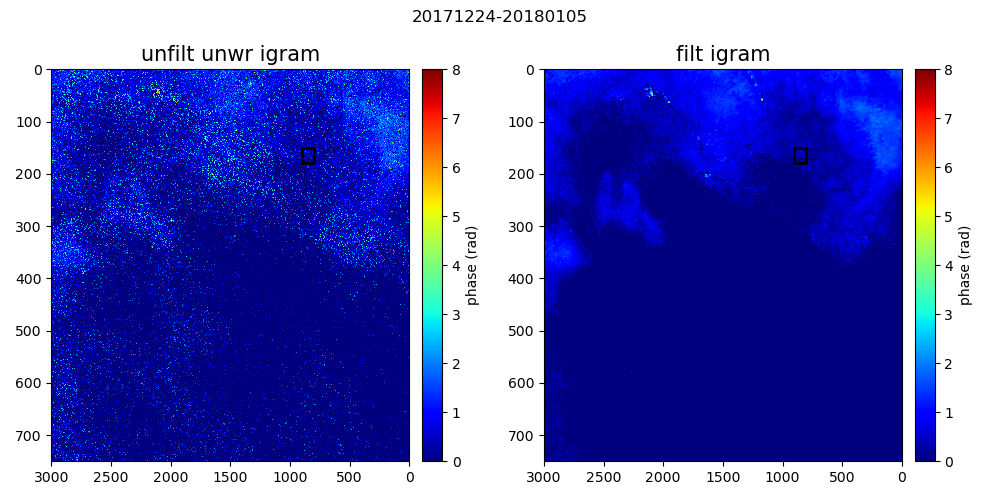

In [3]:
#k = 15 # which igram to plot? 
k = 59
k = 18
date1 = dates[k]; date2 = dates[k+1]
plt.figure(figsize=(10,5),tight_layout=True) 
plt.subplot(1,2,1)
plt.imshow(unwr_full_res[k],aspect='auto',interpolation='nearest',extent=[0,dx,dy,0],vmin=0,vmax=8)
#plt.imshow(unwr_full_res[k],aspect='auto',interpolation='nearest',extent=[0,dx,dy,0],vmin=-3,vmax=4)
plt.colorbar(orientation='vertical',pad=0.03,label='phase (rad)'); plt.set_cmap('jet')
plt.xlim([dx,0]); plt.ylim([dy,0])
#plt.xticks([]); plt.yticks([]) # this takes xlabels and ylabels away 
plt.title('unfilt unwr igram',fontsize=15)
# add another box for the area I'll use as the reference region later. 
plt.gca().add_patch(Rectangle((800,150),100,30,edgecolor='k',facecolor='none',linewidth=2))
plt.subplot(1,2,2)
plt.imshow(unwr_filt[k],aspect='auto',interpolation='nearest',extent=[0,dx,dy,0],vmin=0,vmax=8)
plt.colorbar(orientation='vertical',pad=0.03,label='phase (rad)'); plt.set_cmap('jet')
plt.xlim([dx,0]); plt.ylim([dy,0])
plt.title('filt igram',fontsize=15)
plt.gca().add_patch(Rectangle((800,150),100,30,edgecolor='k',facecolor='none',linewidth=2))
plt.suptitle(str(date1)+'-'+str(date2))
plt.show()
#plt.savefig("sample_igram_1_AGU.png", transparent=True)

Define two points: a point in LS and a point in open desert. One is considered a reference point because it's all relative.

In [4]:
refpoint = [150,800] # ref region upper right point 
comparepoint = [300,1500] # point in LS 

# ref region 
#Rectangle((800,150),100,30,edgecolor='k',facecolor='none',linewidth=2)

# find average unwr phase value for each igram 
avg_igram_vals = np.mean(unwr_full_res,axis=(1,2))
print(np.shape(avg_igram_vals))

(210,)


Pull out the time series for the one point relative to the reference point

In [5]:
# initialize arrays to hold time series for each point
ref_dx = 100
ref_dy = 30
num_pixels = ref_dx*ref_dy

disps_ref_to_avg = np.zeros((numIgrams,ref_dx*ref_dy),dtype='float')
disps_ref_to_point = np.zeros((numIgrams,ref_dx*ref_dy),dtype='float')
count = 0
# these are rates in (radians/igram interval)
for j in range(ref_dy):
    for k in range(ref_dx):
        # making sure to subtract off the reference point 
        disps_ref_to_avg[:,count] = unwr_full_res[:,comparepoint[0]+j,comparepoint[1]+k] - avg_igram_vals
        disps_ref_to_point[:,count] = unwr_filt[:,comparepoint[0]+j,comparepoint[1]+k] - unwr_filt[:,refpoint[0]+j,refpoint[1]+k]
        count += 1
# calculate cumulative displacement in radians 
cum_disps_ref_to_avg = np.cumsum(disps_ref_to_avg,axis=0) # this and next are cumulative disp in (rad)
cum_disps_ref_to_point = np.cumsum(disps_ref_to_point,axis=0)

Pull out dates in order to plot the time series

In [6]:
# dates is a list of strings, convert strings to datetime objects 
slc_dates=[]
for i in range(0,len(dates)):
    slc_dates.append(datetime.strptime(str(dates[i]).replace('\n',''), '%Y%m%d'))
# take numIgrams and pull out the igram_dates, corresponding to the first day of each igram
igram_dates = slc_dates[1::] # using second SLC date as the igram date, per Rowena's suggestion
dt1 = np.diff(slc_dates) # calculate dt between slcs, these are now timedelta objects
# convert to floats 
dt = np.zeros([len(dt1),1])
for i in range(len(dt)):
    dt[i] = dt1[i].days #/365.25 # dt is now an array of floats (years btw slc acquisitions)
print('slc_dates: '+str(np.shape(slc_dates)))
print('igram_dates: '+str(np.shape(igram_dates)))
print('^datetime objects now')
#print(dt)

slc_dates: (211,)
igram_dates: (210,)
^datetime objects now


Load precip data to plot vertical lines where big (>threshhold) storms occurred

In [7]:
# Read in 2day precipitation data
precip = np.loadtxt('/data/ocp4/LagunaSalada/3_precip/precip_2days.txt', dtype='float')
#precip = np.loadtxt('/data/ocp4/LagunaSalada/3_precip/precip_cumulative.txt', dtype='float')

# BIGGER STORMS
# days with precip > 0.3cm 
#print('i \tdate \t\t       precip > 0.3cm')
print('i \tdate \t\t       precip > 0.0cm')
rain_dates = []
for i in np.arange(len(precip)): 
    if precip[i] > 0.0:
        print(str(i)+'\t'+str(slc_dates[i])+'    '+str(precip[i])+' cm')
        rain_dates.append(slc_dates[i])

i 	date 		       precip > 0.0cm
0	2017-05-10 00:00:00    0.33020000000000005 cm
47	2018-12-07 00:00:00    5.0546 cm
55	2019-03-13 00:00:00    0.0762 cm
59	2019-05-12 00:00:00    0.10160000000000001 cm
74	2019-09-27 00:00:00    1.4478 cm
83	2019-11-20 00:00:00    2.286 cm
86	2019-12-08 00:00:00    0.254 cm
97	2020-02-12 00:00:00    1.1684 cm
102	2020-03-13 00:00:00    0.40640000000000004 cm
103	2020-03-19 00:00:00    0.254 cm
107	2020-04-12 00:00:00    0.9906 cm
154	2021-01-25 00:00:00    0.0762 cm
186	2021-08-11 00:00:00    0.381 cm


Load in coherence.

In [8]:
saveDir = '/data/ocp4/LagunaSalada/2_coherence/coh_tip_LS_all_igrams/'
coh = np.ndarray((np.shape(unwr_full_res)),dtype='float')
for i in range(numIgrams): #range(numIgrams)
    date1=dates[i]
    date2=dates[i+1]
    file_name = 'coh_'+str(date1)+'_'+str(date2)+'.r4'
    f1 = gdal.Open(saveDir+file_name, gdal.GA_ReadOnly)
    coh[i] = f1.ReadAsArray()
f1 = None
print('Coh maps loaded.')

Coh maps loaded.


Pull out average coherence value in reference region over time.

In [9]:
coh_at_ref = np.zeros((numIgrams,),dtype='float')
min_coh_at_ref = np.zeros((numIgrams,),dtype='float')

for i in range(numIgrams):
    coh_at_ref[i] = np.mean((coh[i,refpoint[0]:refpoint[0]+ref_dy,refpoint[1]:refpoint[1]+ref_dx]).flatten())
    min_coh_at_ref[i] = min((coh[i,refpoint[0]:refpoint[0]+ref_dy,refpoint[1]:refpoint[1]+ref_dx]).flatten())

print('Avg coherence in reference region calculated.')
#print(np.sort(coh_at_ref))

Avg coherence in reference region calculated.


In [10]:
print(np.sort(min_coh_at_ref))

[0.15965751 0.18814793 0.27351081 0.34286088 0.35665902 0.36346343
 0.38784507 0.41224948 0.44061869 0.44263709 0.46911404 0.47995624
 0.49289986 0.49968413 0.50559443 0.50998133 0.51373374 0.54501063
 0.55886495 0.57257158 0.60646522 0.61078775 0.63301456 0.65669358
 0.65745884 0.66133785 0.6642766  0.67583042 0.68688709 0.688573
 0.68860275 0.69334912 0.69580948 0.69838399 0.69899184 0.70897394
 0.71013069 0.71406913 0.72488028 0.72570091 0.72583854 0.73120219
 0.73366171 0.73514426 0.73565984 0.73698562 0.73785174 0.73815072
 0.74059272 0.74317616 0.74322867 0.74959451 0.75205791 0.75288284
 0.75749159 0.75793964 0.75861847 0.75931513 0.76246512 0.76587772
 0.76639563 0.77130234 0.77186745 0.77357423 0.77371353 0.77395314
 0.77582705 0.77677178 0.78042376 0.7808342  0.7818135  0.78282571
 0.785326   0.78535283 0.78565866 0.78571105 0.78658313 0.78726643
 0.78744608 0.78810555 0.78973508 0.7911635  0.79123193 0.79273283
 0.79304254 0.79351026 0.79369038 0.79402727 0.79445851 0.794801

Now out of all the time series we produced, get values for each time of 1 sigma above median and 1 sigma below median to represent the spread of the data. Calculates which data is 1sigma above+below the median using the sorted list and the 68th percentile (34th above median, 34th below median).

In [11]:
# calculate time series for one standard deviation above median, one below median 
upper = np.zeros((len(igram_dates),)); upper_cum = np.zeros((len(igram_dates),)); median = np.zeros((len(igram_dates),))
lower = np.zeros((len(igram_dates),)); lower_cum = np.zeros((len(igram_dates),)); median_cum = np.zeros((len(igram_dates),))

upper_filt = np.zeros((len(igram_dates),)); upper_cum_filt = np.zeros((len(igram_dates),)); median_filt = np.zeros((len(igram_dates),))
lower_filt = np.zeros((len(igram_dates),)); lower_cum_filt = np.zeros((len(igram_dates),)); median_cum_filt = np.zeros((len(igram_dates),))

single_date_disps_ref_to_avg = np.zeros((num_pixels,)); single_date_cum_disps_ref_to_avg = np.zeros((num_pixels,))
single_date_disps_ref_to_point = np.zeros((num_pixels,)); single_date_cum_disps_ref_to_point = np.zeros((num_pixels,))

# make indices that line up to the 1sigma above and below the median:
above_index = int(num_pixels*0.5+0.34135*num_pixels)
below_index = int(num_pixels*0.5-0.34135*num_pixels)
median_index = int(num_pixels*0.5)
print('index of data point 1\u03C3 above median: '+str(above_index))
print('index of data point 1\u03C3 below median: '+str(below_index))
print('index of median data point: '+str(median_index))
# loop through each igram date
for i in range(len(igram_dates)): #len(igram_dates)
    # sort the values 
    single_date_disps_ref_to_avg = sorted(disps_ref_to_avg[i,:])
    single_date_disps_ref_to_point = sorted(disps_ref_to_point[i,:])
    #print(single_date_disps[0],single_date_disps[-1])
    upper[i] = single_date_disps_ref_to_avg[above_index]; upper_filt[i] = single_date_disps_ref_to_point[above_index]
    lower[i] = single_date_disps_ref_to_avg[below_index]; lower_filt[i] = single_date_disps_ref_to_point[below_index]
    median[i] = single_date_disps_ref_to_avg[median_index]; median_filt[i] = single_date_disps_ref_to_point[median_index]
    single_date_cum_disps_ref_to_avg = sorted(cum_disps_ref_to_avg[i,:]); single_date_cum_disps_ref_to_point = sorted(cum_disps_ref_to_point[i,:])
    upper_cum[i] = single_date_cum_disps_ref_to_avg[above_index]; upper_cum_filt[i] = single_date_cum_disps_ref_to_point[above_index]
    lower_cum[i] = single_date_cum_disps_ref_to_avg[below_index]; lower_cum_filt[i] = single_date_cum_disps_ref_to_point[below_index]
    median_cum[i] = single_date_cum_disps_ref_to_avg[median_index]; median_cum_filt[i] = single_date_cum_disps_ref_to_point[median_index]
#print(np.shape(disp_rates))
#print(np.shape(cum_disps))

index of data point 1σ above median: 2524
index of data point 1σ below median: 475
index of median data point: 1500


Plot the time series with vertical lines for storms (>threshold precip) and 1sigma above+below the median, with median also.

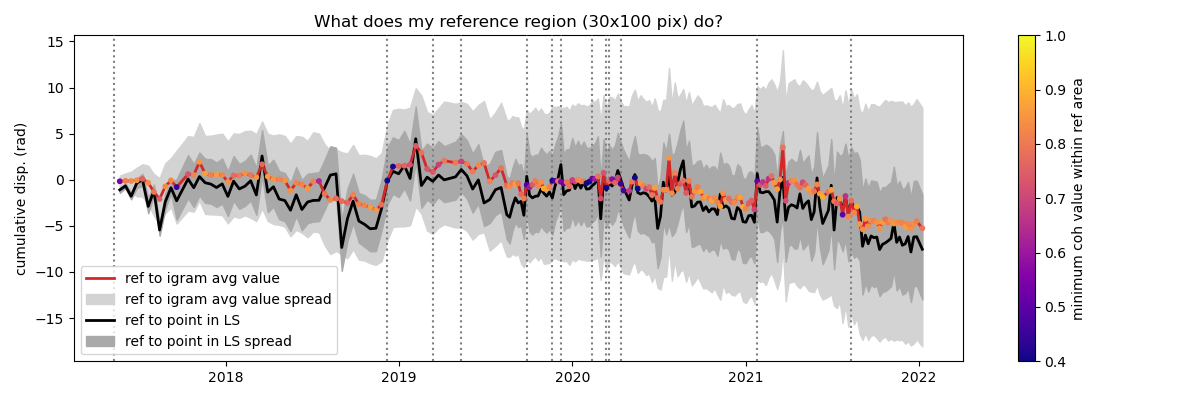

In [12]:
plt.figure(figsize=(12,4),tight_layout='TRUE')
color_to_use = 'tab:red'
plt.plot(igram_dates,median_cum,color=color_to_use,linewidth=2,label='ref to igram avg value',zorder=15) # purple,tab:orange,tab:green,tab:blue
plt.scatter(igram_dates,median_cum,c=min_coh_at_ref,cmap='plasma',s=10,vmin=0.4,vmax=1.0,zorder=20)
plt.colorbar(label='minimum coh value within ref area')
plt.fill_between(igram_dates,lower_cum,upper_cum,color='lightgray',label='ref to igram avg value spread',zorder=0)
plt.plot(igram_dates,median_cum_filt,color='k',linewidth=2,label='ref to point in LS',zorder=10)
plt.fill_between(igram_dates,lower_cum_filt,upper_cum_filt,color='darkgray',label='ref to point in LS spread',zorder=1)
Ymin,Ymax = plt.gca().get_ylim()
plt.vlines(rain_dates,Ymin,Ymax,'gray',':',zorder=5)
plt.ylim([Ymin,Ymax])
plt.legend(loc='lower left'); 
#plt.title('Cum. disp. btw sets of '+str(num_pixels)+' pixels (rad)')
plt.ylabel('cumulative disp. (rad)'); #plt.xlabel('date')
plt.title('What does my reference region (30x100 pix) do?')
plt.show()
#plt.savefig("time_series_g-h.pdf", transparent=True)

Convert to cm 

In [13]:
# make a conversion factor from radians to cm 
wavelength = 5.5465763
rad2cm = wavelength/(4*np.pi) # this is conversion factor that I multiply by the data (which is in rads)

median_cum_cm = median_cum*rad2cm; median_cum_filt_cm = median_cum_filt*rad2cm
lower_cum_cm = lower_cum*rad2cm; lower_cum_filt_cm = lower_cum_filt*rad2cm
upper_cum_cm = upper_cum*rad2cm; upper_cum_filt_cm = upper_cum_filt*rad2cm
print('cumulative displacements converted to cm.')

# convert 2pi radians to cm 
twoPi_interval_cm = np.pi*2*rad2cm
print('2\u03C0 radians = '+str(twoPi_interval_cm)+' cm')

cumulative displacements converted to cm.
2π radians = 2.77328815 cm


Now plot the same plot but in cm now (instead of radians like before) and plot horizontal lines where 2pi radian jumps exist

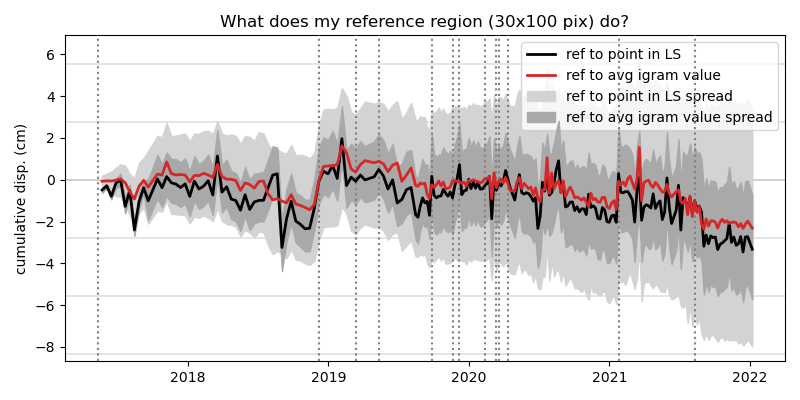

In [14]:
plt.figure(figsize=(8,4),tight_layout='TRUE')
color_to_use = 'tab:red'
plt.plot(igram_dates,median_cum_filt_cm,color='k',linewidth=2,label='ref to point in LS',zorder=15)
plt.plot(igram_dates,median_cum_cm,color=color_to_use,linewidth=2,label='ref to avg igram value',zorder=20) # purple,tab:orange,tab:green,tab:blue
plt.fill_between(igram_dates,lower_cum_cm,upper_cum_cm,color='lightgray',label='ref to point in LS spread',zorder=5)
plt.fill_between(igram_dates,lower_cum_filt_cm,upper_cum_filt_cm,color='darkgray',label='ref to avg igram value spread',zorder=8)
Ymin,Ymax = plt.gca().get_ylim()
# calculate btw Ymin and Ymax where the 2pi rad multiples are
grid_multiples = []
count1 = 0
while (count1*twoPi_interval_cm < Ymax):
    grid_multiples.append(count1*twoPi_interval_cm)
    count1+=1
count1 = 0
while (count1*twoPi_interval_cm > Ymin):
    grid_multiples.append(count1*twoPi_interval_cm)
    count1-=1
#print(grid_multiples)
plt.vlines(rain_dates,Ymin,Ymax,'gray',':',zorder=10)
Xmin,Xmax = plt.gca().get_xlim()
plt.hlines(grid_multiples,Xmin,Xmax,'gray',linewidth=0.3,zorder=0)
plt.ylim([Ymin,Ymax]); plt.xlim([Xmin,Xmax]); plt.legend()
#plt.title('Cum. disp. btw sets of '+str(num_pixels)+' pixels (cm)')
plt.ylabel('cumulative disp. (cm)'); #plt.xlabel('date')
yval = -10.0
linewid = 6.0
plt.hlines(yval,igram_dates[0],igram_dates[46],color='gold',linewidth=linewid,zorder=10)
plt.hlines(yval,igram_dates[47],igram_dates[107],color='hotpink',linewidth=linewid,zorder=10)
plt.hlines(yval,igram_dates[108],igram_dates[146],color='olive',linewidth=linewid,zorder=10)
plt.hlines(yval,igram_dates[147],igram_dates[-1],color='coral',linewidth=linewid,zorder=10)
plt.hlines(yval-1.0,igram_dates[0],igram_dates[88],color='cornflowerblue',linewidth=linewid,zorder=10)

plt.title('What does my reference region (30x100 pix) do?')
plt.show()
#plt.savefig("time_series_g-h_with_time_blocks.pdf", transparent=True)